In [1]:
%matplotlib inline
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import os
from sklearn.preprocessing import LabelEncoder
from sklearn.cross_validation import KFold
from sklearn.metrics import log_loss

# Phone brand and device model based benchmarks

The task in this competition is to predict a user's age and gender group using information about their mobile phone model and usage patterns.

Since many of the devices have no events data it's interesting to know how much information we can extract from phone brand and device model only. This notebook contains some benchmark approaches of inferring age and gender from data contained in `phone_brand_device_model.csv`.

CV scores of different approaches obtained by 10-fold cross-validation are as follows:

* 2.485 - 1/n_classes benchmark
* 2.428 - class probabilities benchmark
* 2.420 - predicting gender from phone brand
* 2.417 - predicting gender from device model
* 2.402 - predict gender-age group from phone brand
* 2.395 - predict gender-age group from device model
* 2.391 - mean of last two

Some notes from the exploratory analysis:

* Some device models could belong to different brands. So the correct way to label encode device model is to concatenate with brand first.
* `phone_brand_device_model.csv` contains double entries for 529 device_ids. Most of these duplicate rows are identical and can be safely dropped, but six devices actually have different information in their rows. Of these 1 belongs to the train set and 5 to the test set.

## Demographic data

In [3]:
gatrain = pd.read_csv('../input/gender_age_train.csv')
gatest = pd.read_csv('../input/gender_age_test.csv')
gatrain.head(3)

,device_id,gender,age,group
0,-8076087639492063270,M,35,M32-38
1,-2897161552818060146,M,35,M32-38
2,-8260683887967679142,M,35,M32-38


In [4]:
gatrain.shape[0] - gatrain.device_id.nunique()

0

In [ ]:
gatest.shape[0] - gatest.device_id.nunique()

None, great.

### Age and gender distributions

Counts of target groups

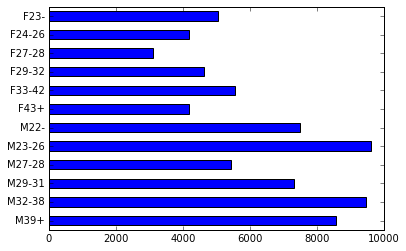

In [5]:
gatrain.group.value_counts().sort_index(ascending=False).plot(kind='barh')

Gender counts

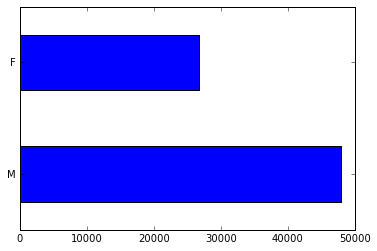

In [6]:
gatrain.gender.value_counts().plot(kind='barh')

Age distribution, lines denote target groups.

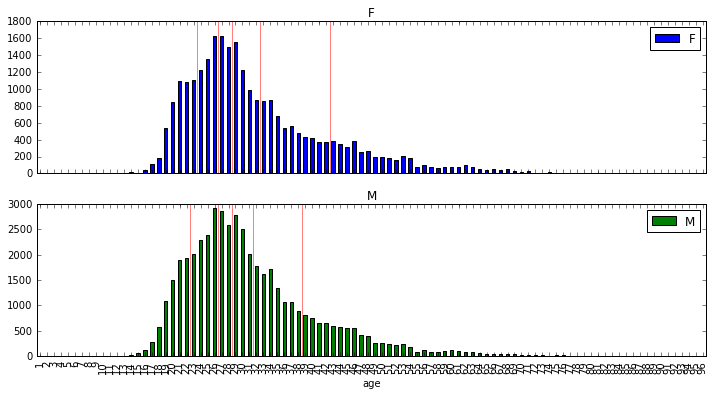

In [7]:
c = gatrain.groupby(['age','gender']).size().unstack().reindex(index=np.arange(gatrain.age.min(), gatrain.age.max()+1)).fillna(0)
ax1, ax2 = c.plot(kind='bar',figsize=(12,6),subplots=True);
ax1.vlines(np.array([23,26,28,32,42])-0.5,0,1800,alpha=0.5,linewidth=1,color='r')
ax2.vlines(np.array([22,26,28,31,38])-0.5,0,3000,alpha=0.5,linewidth=1,color='r')

### 1/n_classes benchmark

In [8]:
letarget = LabelEncoder().fit(gatrain.group.values)
y = letarget.transform(gatrain.group.values)
n_classes = len(letarget.classes_)

In [17]:
gatrain.shape[0]

74645

In [9]:
pred = np.ones((gatrain.shape[0],n_classes))/n_classes
log_loss(y, pred)

2.4849066497880012

### Class probabilities benchmark

Best we can do without any features.

In [18]:
pred = np.zeros((gatrain.shape[0],n_classes))

array([[ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.],
       [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.]])

In [14]:
kf = KFold(gatrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((gatrain.shape[0],n_classes))
for itrain, itest in kf:
    train = gatrain.iloc[itrain,:]
    test = gatrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    prob = train.groupby('group').size()/train.shape[0]
    pred[itest,:] = prob.values
print(log_loss(y, pred))

2.42805122275


## Phone brand and model data

In [19]:
phone = pd.read_csv('../input/phone_brand_device_model.csv',encoding='utf-8')
phone.head(3)

,device_id,phone_brand,device_model
0,-8890648629457979026,小米,红米
1,1277779817574759137,小米,MI 2
2,5137427614288105724,三星,Galaxy S4


In [20]:
print('{} rows'.format(phone.shape[0]))
print("unique values:")
for c in phone.columns:
    print('{}: {}'.format(c, phone[c].nunique()))

187245 rows
unique values:
device_id: 186716
phone_brand: 131
device_model: 1599


### Duplicate devide_ids

In [21]:
dup = phone.groupby('device_id').size()
dup = dup[dup>1]
dup.shape

(529,)

In [22]:
dup.value_counts()

2    529
dtype: int64

529 device ids have duplicate entries in phone dataframe. Are duplicate rows identical or different?

In [23]:
dup = phone.loc[phone.device_id.isin(dup.index)]
first = dup.groupby('device_id').first()
last = dup.groupby('device_id').last()

In [24]:
diff = (first != last).sum(axis=1).nonzero()
pd.concat((first.iloc[diff], last.iloc[diff]),axis=1)

,phone_brand,device_model,phone_brand,device_model
device_id,,,,
-7297178577997113203,华为,荣耀畅玩5X,华为,荣耀3C
-7059081542575379359,LG,Nexus 5,魅族,魅蓝Note 2
-6590454305031525112,小米,MI 3,华为,荣耀6 Plus
-5269721363279128080,三星,Galaxy Core Advance,小米,MI 3
-3004353610608679970,酷派,5891,酷派,7296
5245428108336915020,魅族,MX4,小米,MI One Plus


Looks like 6 devices with duplicate rows have different values for brand and model. Are they in train or in test?

In [25]:
dev = _.index
print("in train: {}".format(sum(gatrain.device_id.isin(dev))))
print("in test: {}".format(sum(gatest.device_id.isin(dev))))

in train: 1
in test: 5


For now just drop duplicates.

In [26]:
phone = phone.drop_duplicates('device_id', keep='first')

### Any models that can belong to different brands?

In [27]:
c = phone.groupby('device_model')['phone_brand'].apply(pd.Series.nunique)
c.value_counts()

1    1545
2      43
3       8
4       3
Name: phone_brand, dtype: int64

Some device models can belong to more than one brand. So the correct way to label-encode device models is probably to concatenate with brand first.

In [28]:
lebrand = LabelEncoder().fit(phone.phone_brand)
phone['brand'] = lebrand.transform(phone.phone_brand)
m = phone.phone_brand.str.cat(phone.device_model)
lemodel = LabelEncoder().fit(m)
phone['model'] = lemodel.transform(m)

### Brands and models popularity

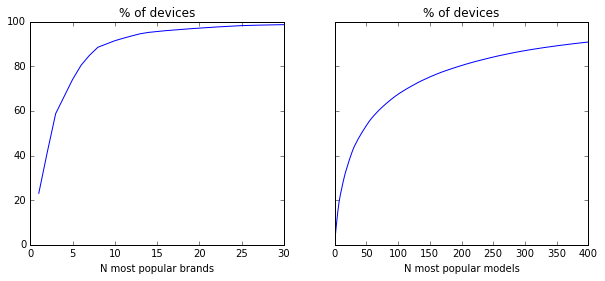

In [29]:
c = phone.brand.value_counts()
s = c.cumsum()/c.sum()
fig, (ax1,ax2) = plt.subplots(1,2,sharey=True,figsize=(10,4))
ax1.plot(np.arange(s.shape[0])+1, s.values*100)
ax1.set_xlim(0,30)
ax1.set_xlabel('N most popular brands')
ax1.set_title('% of devices');
c = phone.model.value_counts()
s = c.cumsum()/c.sum()
ax2.plot(np.arange(s.shape[0])+1, s.values*100)
ax2.set_xlim(0,400)
ax2.set_xlabel('N most popular models')
ax2.set_title('% of devices');

9 most popular brands account for 90% of devices. For models the number to account for 90% of devices is 373.

### Gender ratios by phone brand

In [30]:
train = gatrain.merge(phone[['device_id','brand','model']], how='left',on='device_id')

In [31]:
def plot_by(df, cat, by, perc = 0.95):
    # Find popular categories
    c = df[by].value_counts().cumsum()/df.shape[0]
    take = c[c<=perc].index
    # Pool rare categories into 'other' cat
    gr = df[by].copy()
    gr[~(df[by].isin(take))] = 'other'
    # Count target classes in groups
    c = df.groupby([gr,cat]).size().unstack().fillna(0)
    total = c.sum(axis=1)
    meanprobs = c.sum(axis=0).cumsum()/df.shape[0]
    # Transform to probabilities
    sortcol = c.columns[int(np.floor((c.shape[1]-1)/2))]
    c = c.div(c.sum(axis=1), axis='index')
    # Cumsum for stacked bars
    c = c.cumsum(axis=1).sort_values(by=sortcol)
    total = total.loc[c.index]
    # Prepare plot data
    left = np.array([0, *(total.iloc[:-1].cumsum().values)])
    ticks = left + 0.5*total.values
    colors = cm.rainbow(np.linspace(0.1,0.9,num=c.shape[1]))
    fig, ax = plt.subplots(figsize=(10,5))
    for (i,col) in enumerate(c.columns[::-1]):
        height = c[col].values
        ax.bar(left, height, total.values,label=col,color=colors[i],zorder = c.shape[0]+i)
    for p in meanprobs.iloc[:-1]:
        ax.hlines(p, 0, total.sum(),
                  color='w',alpha=0.6,zorder=c.shape[0]*10,linewidth=1)
    # legend placement needs more work
    ax.legend(bbox_to_anchor=(1.1, 0.8),title=cat)
    ax.set_xticks(ticks)
    ax.set_xticklabels(total.index, rotation='vertical')
    ax.set_xlabel(by)
    ax.set_xlim(0,left[-1]+total.values[-1])
    return ax

Bar widths represent group counts, ratio of genders in each group is shown. The line represents overall genders ratio.

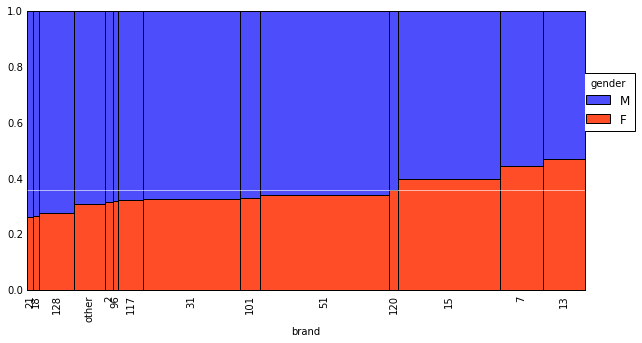

In [32]:
ax = plot_by(train, 'gender','brand')

In [33]:
# brands preferred by female users
lebrand.classes_[[15, 7, 13]]

array(['三星', 'OPPO', 'vivo'], dtype=object)

What about models?

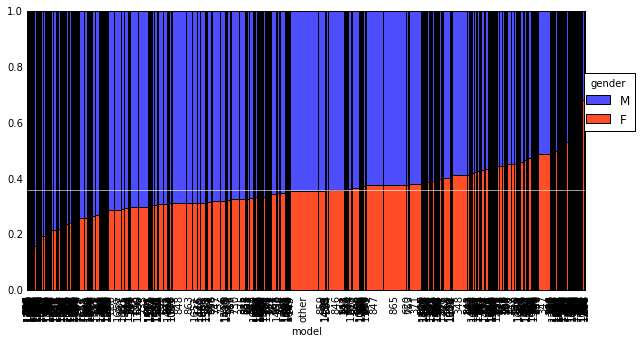

In [34]:
ax = plot_by(train, 'gender','model')

Way too many device models here...

### Age distributions by phone brand

Color = gender


In [2]:
brands = train.brand.value_counts().index[:6]
c = train[train.brand.isin(brands)]
g = sns.FacetGrid(c, hue='gender', col='brand',col_wrap=2, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

NameError: name 'train' is not defined

Mostly look very similar.

### Age distributions by phone model

In [ ]:
models = train.model.value_counts().index[:6]
c = train[train.model.isin(models)]
g = sns.FacetGrid(c, hue='gender', col='model',col_wrap=2, aspect=2, xlim=(15,60))
g.map(sns.distplot, 'age', bins=np.arange(15,70)+0.5)

So do these.

### Benchmark: predict gender from phone brand

In [ ]:
ptrain = gatrain.merge(phone[['device_id','brand','model']], how='left',on='device_id')
ptrain.head(3)

In [ ]:
class GenderProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        self.label = 'pF_' + by
        self.prior = (df['gender']=='F').mean()
        # fit age groups
        prob = train.groupby(['gender','group']).size()
        pF = prob['F']/prob['F'].sum()
        pM = prob['M']/prob['M'].sum()
        self.agegroups = pd.concat((pF,pM),axis=0)
        # fit gender probs by grouping column
        c = (df[['gender']]=='F').groupby(df[by]).agg(['sum','count'])
        s = c[('gender','sum')]
        n = c[('gender','count')]
        prob = (s + self.prior*self.prior_weight) / (n + self.prior_weight)
        self.prob = pd.DataFrame(prob, columns=[self.label])
        return self
    
    def predict_proba(self, df):
        pF = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.label]
        pF = np.reshape(pF.values,(pF.shape[0],1))
        pred = np.zeros((df.shape[0],12))
        pred += self.agegroups.values
        pred[:,:6] *= pF
        pred[:,6:] *= 1-pF
        return pred

In [ ]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
pred = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderProb().fit(train,'brand')
    pred[itest,:] = clf.predict_proba(test)
print(log_loss(y, pred))

Wrap the scoring in a function to try different values for prior_weight.

In [ ]:
def score(ptrain, by, prior_weight=10.):
    kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

In [ ]:
weights = [0.1, 0.5, 1., 5., 10., 20.,40.]
res = [score(ptrain,'brand',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

### Benchmark: predict gender from device model

In [ ]:
weights = [0.1, 0.5, 1., 5., 10., 20.,40.]
res = [score(ptrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

An improvement of about 0.01 when going from predicting class probabilities to predicting gender based on device model.

### Benchmark: predict gender-age group from phone brand

In [ ]:
class GenderAgeGroupProb(object):
    def __init__(self, prior_weight=10.):
        self.prior_weight = prior_weight
    
    def fit(self, df, by):
        self.by = by
        #self.label = 'pF_' + by
        self.prior = df['group'].value_counts().sort_index()/df.shape[0]
        # fit gender probs by grouping column
        c = df.groupby([by, 'group']).size().unstack().fillna(0)
        total = c.sum(axis=1)
        self.prob = (c.add(self.prior_weight*self.prior)).div(c.sum(axis=1)+self.prior_weight, axis=0)
        return self
    
    def predict_proba(self, df):
        pred = df[[self.by]].merge(self.prob, how='left', 
                                left_on=self.by, right_index=True).fillna(self.prior)[self.prob.columns]
        pred.loc[pred.iloc[:,0].isnull(),:] = self.prior
        return pred.values
    
def score(ptrain, by, prior_weight=10.):
    kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
    pred = np.zeros((ptrain.shape[0],n_classes))
    for itrain, itest in kf:
        train = ptrain.iloc[itrain,:]
        test = ptrain.iloc[itest,:]
        ytrain, ytest = y[itrain], y[itest]
        clf = GenderAgeGroupProb(prior_weight=prior_weight).fit(train,by)
        pred[itest,:] = clf.predict_proba(test)
    return log_loss(y, pred)

In [ ]:
weights = [0.5, 1., 5., 10., 20.,40.,100.]
res = [score(ptrain,'brand',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

### Benchmark: predict gender-age group from device model

In [ ]:
weights = [0.5, 1., 5., 10., 20.,40.,100.]
res = [score(ptrain,'model',prior_weight=w) for w in weights]
plt.plot(weights, res)
plt.title('Best score {:.5f} at prior_weight = {}'.format(np.min(res),weights[np.argmin(res)]))
plt.xlabel('prior_weight')

What if we combine predictions from phone brand and device model?

In [ ]:
kf = KFold(ptrain.shape[0], n_folds=10, shuffle=True, random_state=0)
predb = np.zeros((ptrain.shape[0],n_classes))
predm = np.zeros((ptrain.shape[0],n_classes))
for itrain, itest in kf:
    train = ptrain.iloc[itrain,:]
    test = ptrain.iloc[itest,:]
    ytrain, ytest = y[itrain], y[itest]
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'brand')
    predb[itest,:] = clf.predict_proba(test)
    clf = GenderAgeGroupProb(prior_weight=40.).fit(train,'model')
    predm[itest,:] = clf.predict_proba(test)
log_loss(y, 0.5*(predb+predm))

Down ot 2.391.

## Make a submission

In [ ]:
ptest = gatest.merge(phone[['device_id','brand','model']], how='left',on='device_id')
ptest.head(3)

In [ ]:
clf = GenderAgeGroupProb(prior_weight=40.).fit(ptrain,'brand')
predb = clf.predict_proba(ptest)
clf = GenderAgeGroupProb(prior_weight=40.).fit(ptrain,'model')
predm = clf.predict_proba(ptest)

In [ ]:
pd.DataFrame(0.5*(predb+predm), 
             index = ptest.device_id, 
             columns=letarget.classes_).to_csv('pbm_subm.csv', index=True)